# Quantitative Analysis


### AAPL Vs. MSFT

Computing advanced statistical methods to understand, analyze, and compare the inherent risk in two stocks with Bollinger bands, Conditional Value at Risk, Kurtosis analysis, Shapiro-Wilk normality test, and back-test maximum drawdown.

In [109]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


### Data

In [110]:
# Utility Function
def ticker_to_path(ticker, base_dir="stocks_DJIA"):
    """Create the images directory if it does not exist."""
    if not os.path.exists("data"):
        os.makedirs("data")
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(ticker)))


def get_data(tickers, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize(None)
    print(f"df head: {df.head()}")

    if 'SPY' not in tickers:  # add SPY for reference, if absent
        tickers.insert(0, 'SPY')

    for ticker in tickers:
        df_temp = pd.read_csv(ticker_to_path(ticker), 
                              index_col="date", 
                              parse_dates=True,
                              usecols=['date','Adj Close'],
                       na_values=['nan'])
        
        df_temp = df_temp.rename(columns={'Adj Close': ticker})
        df_temp.index = pd.to_datetime(df_temp.index)
        df_temp.index = df_temp.index.tz_localize(None)
        print(f"df_temp head: {df_temp.head()}")
        df = df.join(df_temp)
        if ticker == 'SPY': #Drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df

# Define a date range
dates = pd.date_range('2017-12-12', '2018-12-14')

# Choose stock symbols to read
tickers = ["AAPL", "MSFT"]

# Get stock data
df = get_data(tickers, dates)
    
df = df.dropna(how="any")

#df.rename(columns={'BRK-A': 'AAPL'}, inplace=True)

df head: Empty DataFrame
Columns: []
Index: [2017-12-12 00:00:00, 2017-12-13 00:00:00, 2017-12-14 00:00:00, 2017-12-15 00:00:00, 2017-12-16 00:00:00]
df_temp head:                   SPY
date                 
2000-01-03  95.240279
2000-01-04  91.515799
2000-01-05  91.679513
2000-01-06  90.206092
2000-01-07  95.444921
df_temp head:                 AAPL
date                
2000-01-03  0.850782
2000-01-04  0.779034
2000-01-05  0.790435
2000-01-06  0.722032
2000-01-07  0.756233
df_temp head:                  MSFT
date                 
2000-01-03  36.527069
2000-01-04  35.292369
2000-01-05  35.665286
2000-01-06  34.471325
2000-01-07  34.922586


In [111]:
# forms of data
prices = df.iloc[1:]
returns = np.log(df / df.shift(1)).iloc[1:]

In [112]:
def beta_brk(returns):
    # Create a matrix of [returns, market]
    brk_m = returns.cov().iloc[0,1]

    # Return the covariance of m divided by the standard deviation of the market returns
    return brk_m / returns['SPY'].var()

def beta_MSFT(returns):
    # Create a matrix of [returns, market]
    MSFT_m = returns.cov().iloc[0,2]

    # Return the covariance of m divided by the standard deviation of the market returns
    return MSFT_m / returns['SPY'].var()

print("Annualized Beta for AAPL: ",beta_brk(returns))
print("Annualized Beta for MSFT: ",beta_MSFT(returns))

Annualized Beta for AAPL:  1.2524153875827666
Annualized Beta for MSFT:  1.4504693472242445


### Bollinger Bands

In this part,we compute advanced statistical methods to analyze the investment horizon for both stocks in the past trading-year (252 days). We first introduce the Bollinger bands as a technical indicator for the behavior of the volatility and to explain mean-reversion for both stocks. Bollinger bands consist of computing the moving average for the adjusted closing price for AAPL in a rolling basis of 21 days (monthly) and computing rolling standard deviations of the price. The upper band represents two standard deviations above the moving average and the lower band represents two standard deviations below the moving average.

upper_band: 46.43710148085404
lower_band: 38.938386720507864
prices: 39.8765949392


TypeError: cannot unpack non-iterable numpy.float64 object

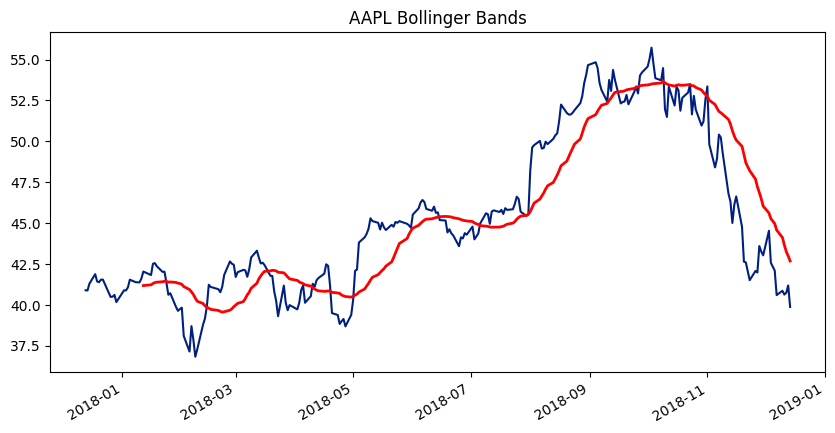

In [113]:
# moving averages (21 days)
# Compute Rolling mean using 21 days window.
rm_brk = prices["AAPL"].rolling(window=21, center=False).mean()

rstd_brk = prices["AAPL"].rolling(window=21, center=False).std()

upper_band = rm_brk + rstd_brk * 2
lower_band = rm_brk - rstd_brk * 2

print(f"upper_band: {upper_band[-1]}")
print(f"lower_band: {lower_band[-1]}")
print(f"prices: {prices['AAPL'][-1]}")

# Plot BRK values, rolling mean and Bollinger Bands
plt.figure(figsize=(10,5))
ax = prices['AAPL'].plot(title="AAPL Bollinger Bands", label='AAPL',color="#002080")
rm_brk.plot(label='Rolling mean', ax=ax, color="r",linewidth=2) #.annotate(f"{upper_band[-1]}", xy=(prices['AAPL'][-1]))
upper_band.plot(label='Upper band', ax=ax,linewidth=2,color="#ff4d4d",style='--')
lower_band.plot(label='Lower band', ax=ax,linewidth=2,color="#ff4d4d",style='--')


# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='lower right')
plt.savefig('data/AAPL_bb.png', dpi=300,bbox_inches='tight')

As seen in the figure above, we observe that AAPL’s Bollinger bands expand for the first months of the year, then contracting significantly, and lastly starting to expand again. This behavior shows us that AAPL’s price has an expected incremental volatility which increases perceived risk, and as a result, trading opportunities for statistical arbitrage and other methods. 

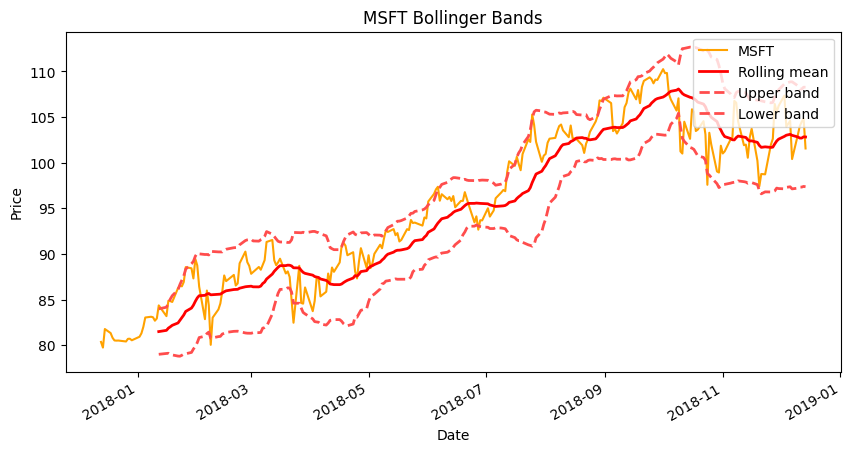

In [ ]:
# Compute Rolling mean using 21 days window.
rm_brk = prices["MSFT"].rolling(window=21, center=False).mean()

rstd_brk = prices["MSFT"].rolling(window=21, center=False).std()

upper_band = rm_brk + rstd_brk * 2
lower_band = rm_brk - rstd_brk * 2

# Plot BRK values, rolling mean and Bollinger Bands
plt.figure(figsize=(10,5))
ax = prices['MSFT'].plot(title="MSFT Bollinger Bands", label='MSFT',color="#FFA200")
rm_brk.plot(label='Rolling mean', ax=ax, color="r",linewidth=2)
upper_band.plot(label='Upper band', ax=ax,linewidth=2,color="#ff4d4d",style='--')
lower_band.plot(label='Lower band', ax=ax,linewidth=2,color="#ff4d4d",style='--')

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper right')

plt.savefig('data/MSFT_bb.png', dpi=300,bbox_inches='tight')

In figure 2 we observe MSFT’s volatility behavior, with a similar behavior to the volatility of AAPL, MSFT’s volatility expands, contracts, and starts expanding back again for the remaining of the year. 

### Risk Management

#### Logarithmic Return distributions, Value at Risk and Conditional Value at Risk 

We then compute the logarithmic returns (log) for each stock to model Value at Risk (VaR). For this, we take the natural logarithm of the division between the current price and the previous price. This will give us a lognormal distribution of returns. With the log returns, we can plot a sorted distribution into a probability density function (PDF) to explain the VaR for a one-day period and the expected shortfall (CVaR) for a more coherent risk measurement for each stock. For all the VaR and CVaR computations, we use a 95% confidence interval. 

A measure of skew between `-2` and `+2` AND kurtosis is between `-7` and `+7` is considered normal.

A measure of lower kurtosis has less outliers in the data than a normal distribution. Price stability is one way this can be looked at. 


5.0% VaR threshold: -2.8692
5.0% CVaR: -4.2278
Kurtosis: 1.8519489281021233
skewness: -0.3596167939882287


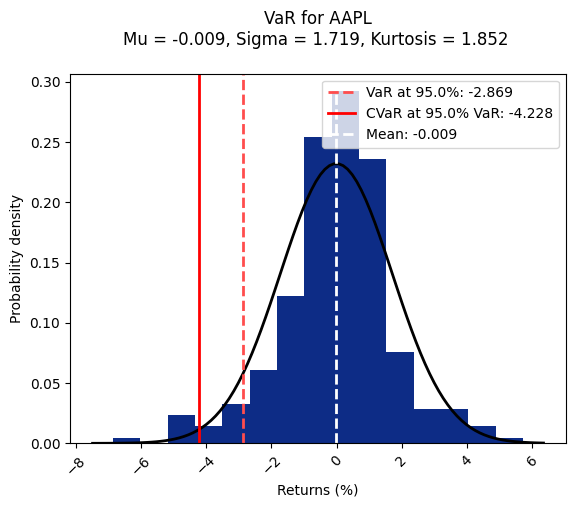

In [ ]:
# VaR parameters
brk_ret = returns['AAPL']
MSFT_ret = returns['MSFT']

distribution = brk_ret*100
confidence = 5
last_value = brk_ret.mean()*100

# Value at Risk
price_array = distribution.sort_values(ascending=True)
var_percentile = np.percentile(price_array, confidence)
val_at_risk = last_value - var_percentile

# CVaR
cvar = price_array[price_array <= var_percentile].mean()

# print
var_percentile_95 = np.percentile(price_array, 5)

val_at_risk_95 = last_value - var_percentile_95

print("5.0% VaR threshold:",round(var_percentile_95,4))

# Conditional VaR
cvar_95 = price_array[price_array <= var_percentile_95].mean()
c_val_at_risk_95 = last_value - cvar_95

print("5.0% CVaR:",round(cvar_95,4))

# Probabilistic Density Function
mu = price_array.mean() 
sigma = price_array.std()  
kurtosis = price_array.kurtosis()
skewness = price_array.skew()
num_bins = int(np.sqrt(len(distribution)))

print("Kurtosis:",kurtosis)
print("skewness:",skewness)
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#002080",label='',alpha=0.95)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Returns (%)')
plt.xticks(rotation=45)
plt.yticks()
plt.ylabel('Probability density')
ax.set_title("VaR for AAPL\nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu,sigma,kurtosis), fontsize=12)
#plt.title(r'VaR for Simulated Prices', fontsize=18, fontweight='bold')
plt.axvline(x=var_percentile, color='#ff4d4d', linestyle='--',linewidth=2, label='VaR at {}%: '.format(str(float(100-confidence))) + str(round(var_percentile,3)))
plt.axvline(x=cvar, color='r', linestyle='-',linewidth=2, label='CVaR at {}% VaR: '.format(str(float(100-confidence))) + str(round(cvar,3)))
plt.axvline(x=last_value, color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(last_value,3)))
ax.set_facecolor('w')
plt.legend(loc="upper right")
plt.savefig('data/AAPL_var.png', dpi=300,bbox_inches='tight')


In figure 3, we observe the logarithmic return distribution for AAPL with a value at risk at -1.91% and an expected shortfall of -3.56%. The returns have an annualized daily return of 0.007% and an annualized volatility of 1.35% and a Sharpe ratio of 0.005. 

5.0% VaR threshold: -2.9348
5.0% CVaR: -3.9322
Kurtosis: 2.4737609791694757
skewness: -0.1446894905311812


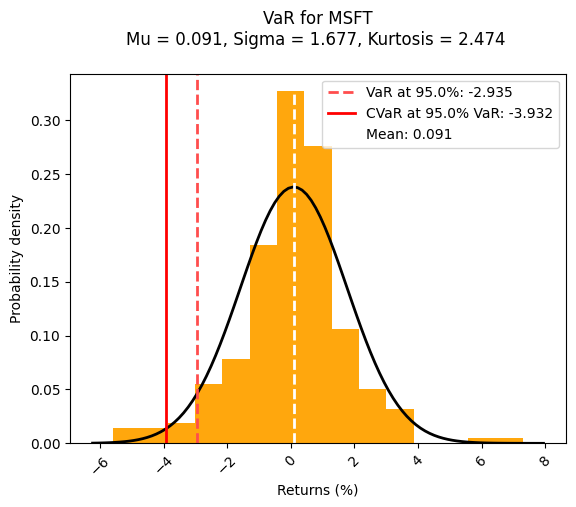

In [ ]:
# VaR parameters
distribution = MSFT_ret*100
confidence = 5
last_value = MSFT_ret.mean()*100

# Value at Risk
price_array = distribution.sort_values(ascending=True)
var_percentile = np.percentile(price_array, confidence)
val_at_risk = last_value - var_percentile

# CVaR
cvar = price_array[price_array <= var_percentile].mean()

# print
var_percentile_95 = np.percentile(price_array, 5)

val_at_risk_95 = last_value - var_percentile_95

print("5.0% VaR threshold:",round(var_percentile_95,4))

# Conditional VaR
cvar_95 = price_array[price_array <= var_percentile_95].mean()
c_val_at_risk_95 = last_value - cvar_95

print("5.0% CVaR:",round(cvar_95,4))

# Probabilistic Density Function
mu = price_array.mean() 
sigma = price_array.std()  
kurtosis = price_array.kurtosis()
skewness = price_array.skew()
num_bins = int(np.sqrt(len(distribution)))

print("Kurtosis:",kurtosis)
print("skewness:",skewness)
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#FFA200",label='',alpha=0.95)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Returns (%)')
plt.xticks(rotation=45)
plt.yticks()
plt.ylabel('Probability density')
ax.set_title("VaR for MSFT\nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu,sigma,kurtosis), fontsize=12)
#plt.title(r'VaR for Simulated Prices', fontsize=18, fontweight='bold')
plt.axvline(x=var_percentile, color='#ff4d4d', linestyle='--',linewidth=2, label='VaR at {}%: '.format(str(float(100-confidence))) + str(round(var_percentile,3)))
plt.axvline(x=cvar, color='r', linestyle='-',linewidth=2, label='CVaR at {}% VaR: '.format(str(float(100-confidence))) + str(round(cvar,3)))
plt.axvline(x=last_value, color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(last_value,3)))
ax.set_facecolor('w')
plt.legend(loc="upper right")
plt.savefig("data/MSFT_var.png", dpi=300,bbox_inches='tight')

In figure 4, we notice the logarithmic returns distribution for MSFT with a VaR of -3.03% and a CVaR of -4.30% and an annualized return of 0.009 with an annualized volatility of 1.78%  and a Sharpe ratio of 0.0048. The risk measurements for each stock denote that at a one-day period, the stocks have a probability of reaching a potential loss up till the VaR threshold previously explained. With the CVaR, we can explain a more coherent measurement of the expected shortfall or the maximum risk at a given day (without counting total loss), as it takes into consideration the average of all the negative returns surpassing the VaR threshold. In this case, we can observe that AAPL has a VaR and CVaR threshold set higher than that of MSFT’s, explaining that with a constant probability of an expected shortfall for the following day, MSFT is much more exposed to a greater loss. We also computed the annualized beta for each stock’s return, using SPY as the benchmark. AAPL got an annualized beta of 1.35 and MSFT an annualized beta of 1.78. With this, we could further comprehend MSFT’s higher volatility than that of the US market’s primary benchmark. 

### Returns Normality 

#### Normality Test

For a more detailed analysis in the behavior of the logarithmic returns distribution for each stock, we introduce the following statistical methods to understand the distribution of returns for the past 252 days: excess kurtosis, skewness, and Shapiro-Wilk test. 

In [ ]:
# Testing for normality on returns
from scipy import stats

# AAPL Normality
print("AAPL Kurtosis: ", brk_ret.kurtosis())
print("AAPL Skewness: ", brk_ret.skew())

p_value = stats.shapiro(brk_ret)[1] 

if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.") 
else:
    print("Null hypothesis of normality is accepted.")

# MSFT Normality
print("\nMSFT Kurtosis: ", MSFT_ret.kurtosis())
print("MSFT Skewness: ", MSFT_ret.skew())

p_value = stats.shapiro(MSFT_ret)[1] 

if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.") 
else:
    print("Null hypothesis of normality is accepted.")


AAPL Kurtosis:  1.8519489281021242
AAPL Skewness:  -0.35961679398822877
Null hypothesis of normality is rejected.

MSFT Kurtosis:  2.4737609791694757
MSFT Skewness:  -0.14468949053118146
Null hypothesis of normality is rejected.


For AAPL we obtained an excess kurtosis of 4.38, this means that the distribution of returns for AAPL has much more exposure in the tails and diverges significantly from the excess kurtosis of a normal distribution which is 0. In the case of MSFT, its excess kurtosis is of 3.14, which still explains a high level of kurtosis. These levels of kurtosis describe both AAPL and MSFT’s returns highly leptokurtic. Furthermore, the skewness of BRKA’s returns is -0.54 and -0.81 for MSFT’s. the negative skewness describes that the mass of the return distributions is concentrated on the right and therefore makes them right-leaning curves. By being right-leaning, the probability density of negative returns is much higher for both stocks.  Finally, we use the statistical Shapiro-Wilk test. This test has its null hypothesis that the distribution is normally distributed. We compute the p-value for each distribution and set the p-value threshold to a confidence interval of 95%. In the results, we got that both distributions have their null hypothesis rejected. This finally concludes that neither stock return distribution behaves in a normal way. 

### Maximum Drawdown

Lastly, we compute the rolling cumulative returns for each stock to find the maximum drawdown for the past trading-year as a last risk measurement. Maximum drawdown explains the longest gap between the highest peak and lowest trough. 

AttributeError: 'numpy.int64' object has no attribute 'date'

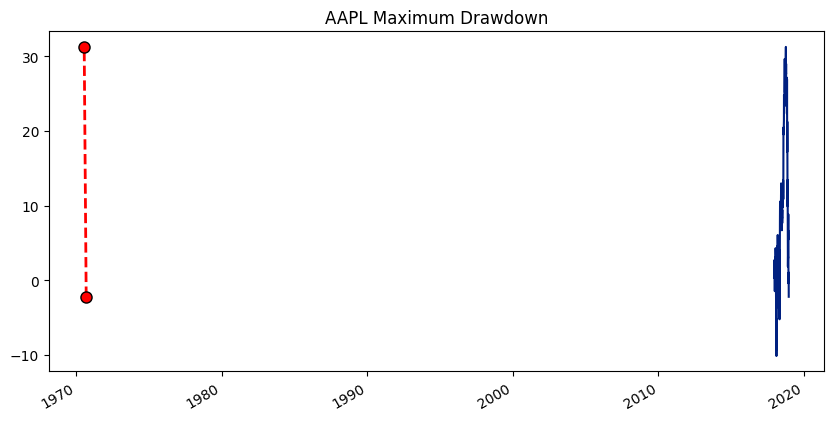

In [ ]:
# Maximum drawdown for AAPL

# Calculating daily drawdowns for the past year
cum_rets = np.cumsum(brk_ret)*100

end = np.argmax(np.maximum.accumulate(cum_rets) - cum_rets) # end of the period
start = np.argmax(cum_rets[:end]) # start of period

plt.figure(figsize=(10,5))
ax = cum_rets.plot(title="AAPL Maximum Drawdown",color="#002080",label='AAPL') 
plt.plot([end, start], [cum_rets[end], cum_rets[start]], '--', color='Red', markersize=10,label='Maximum Drawdown',linewidth=2)
plt.plot([end, start], [cum_rets[end], cum_rets[start]], 'o', color='Red', markersize=8,markeredgecolor='k')

maximum_dd = abs(cum_rets[end]- cum_rets[start])
print("AAPL's maximum drawdown starting from {} to {} with a duration of {}.".format(start.date(),end.date(),end-start))
print("AAPL's Maximum drawdown of {}%.".format(round(maximum_dd,2)))

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns (%)")
ax.legend(loc='lower right')
plt.savefig('data/AAPL_mdd.png', dpi=300,bbox_inches='tight')

In the case of AAPL, we can observe that the maximum drawdown in this year started in January 26 of 2018 and ended in June 27 of the same year with a duration of 152 days. The maximum drawdown for AAPL in percentage was of 14.61%. 

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


LVMUY's maximum drawdown starting from 2018-05-21 to 2018-12-10 with a duration of 203 days 00:00:00.
LVMUY's Maximum drawdown of 26.51%.


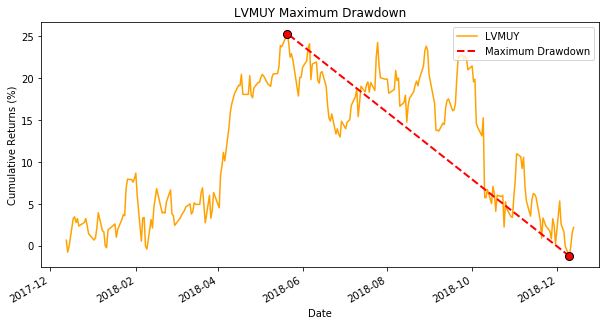

In [ ]:
# Maximum Drawdown for MSFT

# Calculating daily drawdowns for the past year
cum_rets = np.cumsum(MSFT_ret)*100

end = np.argmax(np.maximum.accumulate(cum_rets) - cum_rets) # end of the period
start = np.argmax(cum_rets[:end]) # start of period

plt.figure(figsize=(10,5))
ax = cum_rets.plot(title="MSFT Maximum Drawdown",color="#FFA200",label='MSFT') 
plt.plot([end, start], [cum_rets[end], cum_rets[start]], '--', color='Red', markersize=10,label='Maximum Drawdown',linewidth=2)
plt.plot([end, start], [cum_rets[end], cum_rets[start]], 'o', color='Red', markersize=8,markeredgecolor='k')

maximum_dd = abs(cum_rets[end]- cum_rets[start])
print("MSFT's maximum drawdown starting from {} to {} with a duration of {}.".format(start.date(),end.date(),end-start))
print("MSFT's Maximum drawdown of {}%.".format(round(maximum_dd,2)))

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns (%)")
ax.legend(loc='upper right')
plt.savefig('data/MSFT_mdd.png', dpi=300,bbox_inches='tight')

In the case of MSFT, the maximum drawdown in this year started from May 21st 2018 to December 10th of the same year with a duration of 203 days. The maximum drawdown for MSFT in percentage was of 26.51%. With this, we conclude MSFT’s high and long-lasting maximum drawdown as our last factor to determine MSFT’s much riskier investment based in the back-testing period for the past trading-year. 

### Performance

In [ ]:
# Risk adjusted returns

# Sharpe Ratio AAPL
cagr_b = brk_ret.mean()
vol_b = brk_ret.std()
sharpe_b = cagr_b/vol_b
print("CAGR for AAPL: ", round(cagr_b*100,4))
print("Volatility for AAPL: ", round(vol_b*100,4))
print("Sharpe for AAPL: ", round(sharpe_b,4))

# Sharpe Ratio MSFT
cagr_l = MSFT_ret.mean()
vol_l = MSFT_ret.std()
sharpe_l = cagr_l/vol_l
print("\nCAGR for MSFT: ", round(cagr_l*100,4))
print("Volatility for MSFT: ", round(vol_l*100,4))
print("Sharpe for MSFT: ", round(sharpe_l,4))

CAGR for BRK.A:  0.0067
Volatility for BRK.A:  1.3512
Sharpe for BRK.A:  0.005

CAGR for LVMUY:  0.0086
Volatility for LVMUY:  1.7848
Sharpe for LVMUY:  0.0048
